In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy

from sklearn import cluster

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')

Compute a Medoid for every user.

In [4]:
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'

r = pd.read_csv(file_dir + 'review_without_text_year.csv')
b = pd.read_csv('yelp_business_with_neighborhood.csv')
u = pd.read_csv(file_dir + 'yelp_academic_dataset_user.csv')

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,5,30,50,61,63,80,87,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
rb = pd.merge(r,b, on = 'business_id', how = 'inner')

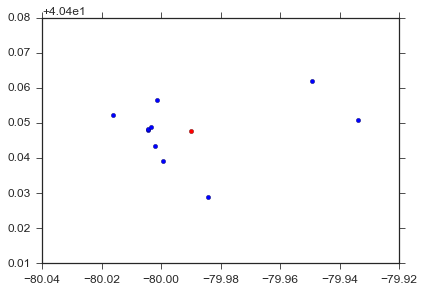

In [26]:
k = 3004
urst = rb[(rb['user_id'] == rb['user_id'][k])]
kmeans = sklearn.cluster.KMeans(n_clusters = 1)
kmeans.fit(urst[['longitude','latitude']].as_matrix())
plt.scatter(urst['longitude'], urst['latitude'])
plt.scatter(kmeans.cluster_centers_[0][0],kmeans.cluster_centers_[0][1],s = 20, c = 'r')

In [32]:
import random
from sklearn.metrics.pairwise import pairwise_distances

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    # randomly initialize an array of k medoid indices
    M = np.sort(np.random.choice(n, k))

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in xrange(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

medoids:
[1 1]
[10 10]

clustering result:
label 0:　[1 1]
label 0:　[2 2]
label 1:　[10 10]


In [45]:
location_data = urst[['longitude','latitude']].as_matrix()

# distance matrix
D = pairwise_distances(location_data, metric='euclidean')

# split into 2 clusters
M, C = kMedoids(D, 1)

print('medoids:')
for point_idx in M:
    print(location_data[point_idx] )

print('')
print('clustering result:')
for label in C:
    for point_idx in C[label]:
        print('label {0}:　{1}'.format(label, location_data[point_idx]))

medoids:
[-80.003366  40.448827]

clustering result:
label 0:　[-80.0015054  40.4566092]
label 0:　[-80.0042395  40.4480678]
label 0:　[-80.0043186  40.4483207]
label 0:　[-79.9337197  40.4507445]
label 0:　[-79.9842819  40.4289537]
label 0:　[-80.003366  40.448827]
label 0:　[-79.949179   40.4620238]
label 0:　[-80.0162318  40.4521448]
label 0:　[-80.002168  40.443358]
label 0:　[-79.9994704  40.4390325]
